In [3]:
%pylab inline --no-import-all
from scikits.audiolab import wavread
from scipy import signal
import matplotlib.pyplot as plt
from scipy.io import wavfile
import math
import numpy as np
from numpy.fft import fft
import pylab

def time(data,rate):
    n=float(data.shape[0]) 
    time= numpy.arange(0, n, 1)
    time = time /rate
    time = time * 100
    return time

def plot(time,data,name):
    plt.plot(time, data, color='G')
    plt.xlabel('Time (ms)')
    plt.ylabel(name)
    plt.show()



Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


sample_rate :  22050
signal.shape :  (66150, 2)
(66150, 2)
66150.0


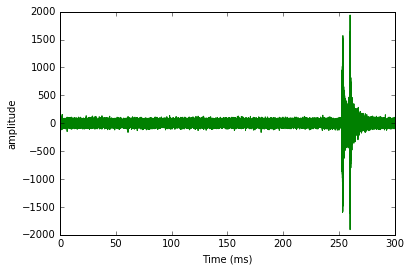

In [11]:
import numpy
import scipy.io.wavfile
from scipy.fftpack import dct
#filename="/Users/kimtaing/Documents/github/MLBD/MLBD/birdsong/NonBecasse/a855.wav"
filename='/Users/kimtaing/Documents/github/MLBD/MLBD/birdsong/BECASSE_FILTREE/3h4.1-EQ37B-01.wav'
sample_rate, signal = scipy.io.wavfile.read(filename)  # File assumed to be in the same directory
print "sample_rate : ",sample_rate
print "signal.shape : ",signal.shape
signal = signal#[int(2.4 * sample_rate):int(2.6* sample_rate)]   #[0:int(3.5 * sample_rate)]  # Keep the first 3.5 seconds
print signal.shape
n=float(signal.shape[0]) 
print n
time= numpy.arange(0, n, 1)
time = time /sample_rate
time = time * 100
plot(time,signal,"amplitude")


In [115]:
dataaudio=signal[:,0]
from IPython.display import Audio
Audio(data=dataaudio,rate=sample_rate)

In [106]:
print "====> print signal[0:5,:]"
print signal[0:5,:]
print "====> print signal[:-1][0:5,:]"
print signal[:-1][0:5,:]
print "====> signal[1:][0:5,:]"
print signal[1:][0:5,:]

====> print signal[0:5,:]
[[  78   58]
 [-134  -94]
 [ -14  -31]
 [  93   89]
 [  12   18]]
====> print signal[:-1][0:5,:]
[[  78   58]
 [-134  -94]
 [ -14  -31]
 [  93   89]
 [  12   18]]
====> signal[1:][0:5,:]
[[-134  -94]
 [ -14  -31]
 [  93   89]
 [  12   18]
 [  -7  -39]]


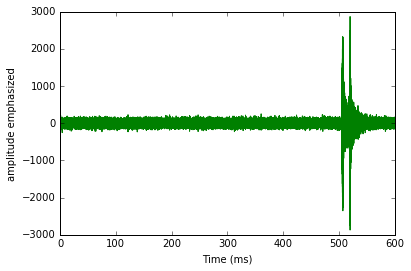

sample_rate :  22050
emphasized_signal.shape :  (132300,)


In [116]:
pre_emphasis = 0.97
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
n=float(emphasized_signal.shape[0])
time= numpy.arange(0, n, 1)
time = time /sample_rate
time = time * 100
plot(time,emphasized_signal,"amplitude emphasized")

print "sample_rate : ",sample_rate
print "emphasized_signal.shape : ",emphasized_signal.shape

In [117]:
dataaudio=emphasized_signal
from IPython.display import Audio
Audio(data=dataaudio,rate=sample_rate)

frame_size :  0.025
frame_stride :  0.01
frame_length (frame_size * sample_rate):  551
frame_step (frame_stride * sample_rate) :  221
signal_length :  132300
num_frames :  597
frames.shape (before pad) (597, 551)
frames.shape (after pad) (597, 551)
frames.shape (after window) (597, 551)
time.shape (597,)


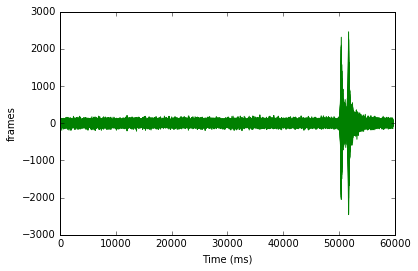

In [108]:
frame_size = 0.025 #25 ms for the frame size
frame_stride = 0.01 #15 ms overlap
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

print "frame_size : ",frame_size
print "frame_stride : ",frame_stride
print "frame_length (frame_size * sample_rate): ",frame_length
print "frame_step (frame_stride * sample_rate) : ",frame_step

print "signal_length : ",signal_length
print "num_frames : ",num_frames
print "frames.shape (before pad)",frames.shape

pad_signal_length = num_frames * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]
print "frames.shape (after pad)",frames.shape


frames *= numpy.hamming(frame_length)
print "frames.shape (after window)",frames.shape

n=float(frames.shape[0]) 
time= numpy.arange(0, n, 1)
#time = time /600
time = time * 100
print "time.shape",time.shape
plot(time,frames,"frames")


In [109]:
from IPython.display import Audio
Audio(data=frames,rate=sample_rate)

mag_frames.shape (597, 257)
pow_frames.shape (597, 257)
time.shape (mag) (597,)


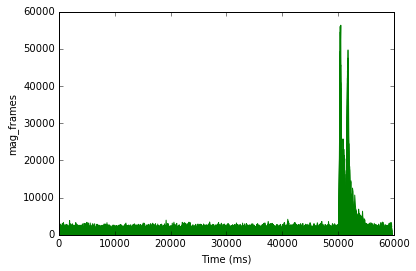

time.shape (pow) (597,)


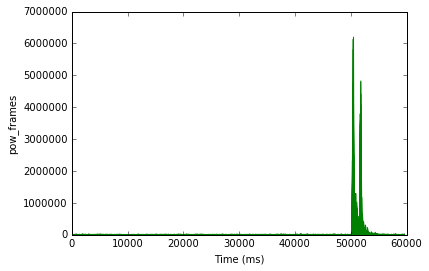

In [110]:
'''
We can now do an N-point FFT on each frame to calculate the frequency spectrum, which is also called Short-Time Fourier-Transform (STFT), where N
N is typically 256 or 512, NFFT = 512; and then compute the power spectrum (periodogram) using the following equation:
'''
NFFT = 512
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

print "mag_frames.shape",mag_frames.shape
print "pow_frames.shape",pow_frames.shape

n=float(mag_frames.shape[0]) 
time= numpy.arange(0, n, 1)
#time = time /600
time = time * 100
print "time.shape (mag)",time.shape
plot(time,mag_frames,"mag_frames")


n=float(pow_frames.shape[0]) 
time= numpy.arange(0, n, 1)
#time = time /600
time = time * 100
print "time.shape (pow)",time.shape
plot(time,pow_frames,"pow_frames")

(597, 40)
(597,)


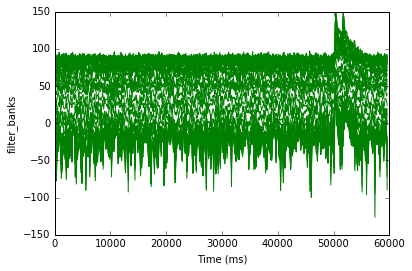

In [111]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB
print filter_banks.shape

n=float(filter_banks.shape[0]) 
time= numpy.arange(0, n, 1)
#time = time /600
time = time * 100
print time.shape
plot(time,filter_banks,"filter_banks")

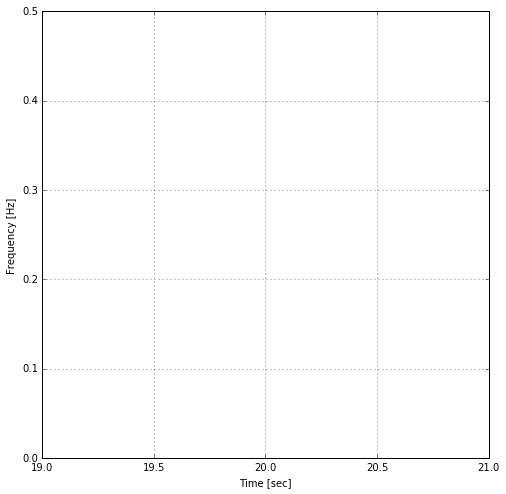

In [112]:
from scipy import signal
f, t, Sxx = signal.spectrogram(filter_banks[1])
plt.figure(figsize=(8,8))
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
#plt.axis([0,0.01,t.min(),t.max()])
plt.grid()
plt.show()

(597, 12)
(597,)


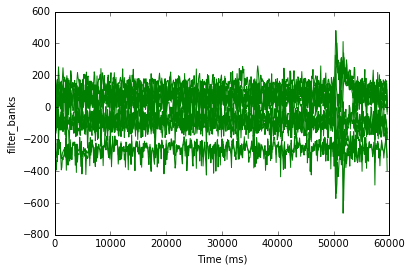

In [97]:
num_ceps = 12
cep_lifter=22
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
(nframes, ncoeff) = mfcc.shape
n = numpy.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
mfcc *= lift  #*
print mfcc.shape

n=float(mfcc.shape[0]) 
time= numpy.arange(0, n, 1)
#time = time /600
time = time * 100
print time.shape
plot(time,mfcc,"filter_banks")

(597, 12)


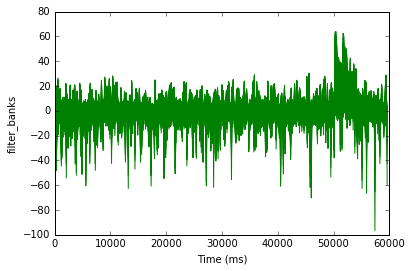

(597,)


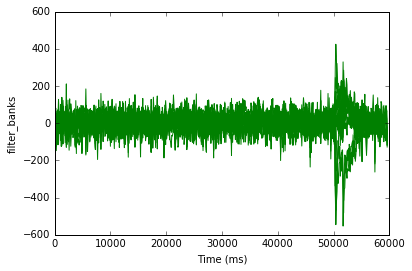

In [99]:
filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)
mfcc -= (numpy.mean(mfcc, axis=0) + 1e-8)
print mfcc.shape
plot(time,filter_banks,"filter_banks")


n=float(mfcc.shape[0]) 
time= numpy.arange(0, n, 1)
#time = time /600
time = time * 100
print time.shape
plot(time,mfcc,"filter_banks")